<a href="https://colab.research.google.com/github/AjeetSingh02/TimeSeries/blob/master/HearBeatUnivariateLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 6

# Basic

In [0]:
import numpy as np
import pandas as pd
from math import sqrt
from matplotlib import pyplot as plt

from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

Using TensorFlow backend.


In [0]:
# load dataset
series = pd.read_csv('subject1.csv', header=0, index_col=0, squeeze=True, parse_dates=["ds"])

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
split_point = int(len(supervised_values)/3)
train, test = supervised_values[0:-split_point], supervised_values[-split_point:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [0]:
# fit the model

train = train_scaled
batch_size = 1
nb_epoch = 3000
neurons = 4
lstm_model = fit_lstm(train, batch_size, nb_epoch, neurons)

In [0]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
pred = lstm_model.predict(train_reshaped, batch_size=1)

In [0]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	# print('instance=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

In [0]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-split_point:], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.381


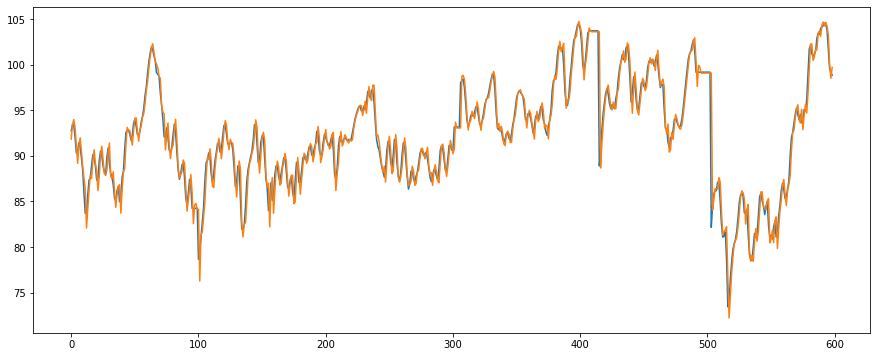

In [0]:
# line plot of observed vs predicted
plt.plot(raw_values[-split_point:])
plt.plot(predictions)
plt.show()

**I am doubtful of these results. Have to check**

# Repeat 

1) Test RMSE: 1.702
2) Test RMSE: 1.709
3) Test RMSE: 1.681
4) Test RMSE: 1.716
5) Test RMSE: 1.713
6) Test RMSE: 1.730
7) Test RMSE: 1.670
           rmse
count  7.000000
mean   1.703046
std    0.020868
min    1.670215
25%    1.691299
50%    1.708765
75%    1.714756
max    1.730232


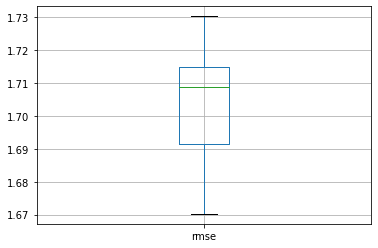

In [0]:
# Going for repeat

# load dataset
series = pd.read_csv('subject1.csv', header=0, index_col=0, squeeze=True, parse_dates=["ds"])

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-257], supervised_values[-257:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# repeat experiment
repeats = 7
error_scores = list()
for r in range(repeats):
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 100, 4)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-257:], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)

# summarize results
results = pd.DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
plt.show()

# Others

Results are same for multiple iterations. I will see some other things to validate

# Approach1

Now we will put in the predicted value back into the forcast instead of putting in original test value.
We will use the test value for the plot.

In [0]:
import numpy as np
import pandas as pd
from math import sqrt
from matplotlib import pyplot as plt

from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# Generate MinMAxscaler object
def generate_scaler(X):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(X)
    return scaler

# Scale 
def scale_mod(scaler, X):
    return scaler.transform(X)

#Inverse scale
def scale_invert_mod(scaler, X):
    return scaler.inverse_transform(X)

# fit an LSTM network to training data
def fit_lstm(X_train, y_train, batch_size, nb_epoch, neurons):
	X = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y_train, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [0]:
# load dataset
series = pd.read_csv('subject3.csv', header=0, index_col=0, squeeze=True, parse_dates=["ds"])

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

X, y = supervised_values[:,0], supervised_values[:,1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train_reshaped = X_train.reshape(-1,1) 
X_test_reshaped = X_test.reshape(-1, 1)
y_train_reshaped = y_train.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

scaler = generate_scaler(X_train_reshaped)

X_train_scaled = scale_mod(scaler, X_train_reshaped)
X_test_scaled = scale_mod(scaler, X_test_reshaped)
y_train_scaled = scale_mod(scaler, y_train_reshaped)
y_test_scaled = scale_mod(scaler, y_test_reshaped)

In [0]:
# fit the model

batch_size = 1
nb_epoch = 3000
neurons = 4
lstm_model = fit_lstm(X_train_scaled, y_train_scaled, batch_size, nb_epoch, neurons)

In [0]:
# forecast the entire training dataset to build up state for forecasting
X_train_scaled = X_train_scaled.reshape(len(X_train_scaled), 1, 1)
pred = lstm_model.predict(X_train_scaled, batch_size=1)

In [0]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(X_test_scaled)):
	# make one-step forecast
	X = X_test_scaled[i]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = scale_invert_mod(scaler, yhat.reshape(-1,1))
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(X_test_scaled)+1-i)
	# store forecast
	predictions.append(yhat[0,0])
	expected = raw_values[len(X_train_scaled) + i + 1]
	print('instance=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

In [0]:
# # report performance
# rmse = sqrt(mean_squared_error(list(raw_values[-594:]), predictions))
# print('Test RMSE: %.3f' % rmse)

In [0]:
# line plot of observed vs predicted
plt.plot(raw_values[-len(X_test_scaled):])
plt.plot(predictions)
plt.show()

In [0]:
# # walk-forward validation on 1st instance of test data
# i = 0
# split_point = len(X_test)
# forecasted = [raw_values[-split_point -1]]

# # make one-step forecast
# X = X_test_scaled[i]
# yhat = forecast_lstm(lstm_model, 1, X)

# # invert scaling
# yhat = scale_invert_mod(scaler, yhat.reshape(-1,1))

# # invert differencing
# yhat = forecasted[-1] + yhat

# # store forecast
# expected = raw_values[len(X_train) + i + 1]
# forecasted.append(yhat[0,0])
# print('instance=%d, Predicted=%f, Expected=%f' % (i, yhat, expected))

In [0]:
# forecasted

[90.3252, 89.41914]

In [0]:
# # walk-forward validation on forecasted instance
# expected_x = []
# for i in range(10):
#     # We will read the last element of forecasted list and
#     # prepare it to make further forcast

#     # make stationary(difference)
#     X = np.array(forecasted[-1] - forecasted[-2])
#     X = X.reshape(-1,1)

#     # do scaling
#     X = scale_mod(scaler, X)

#     # make forecast
#     yhat = forecast_lstm(lstm_model, 1, X)

#     # invert scaling
#     yhat = scale_invert_mod(scaler, yhat.reshape(-1,1))

#     # invert differencing
#     yhat = forecasted[-1] + yhat

#     # store forecast
#     expected = raw_values[len(X_train) + i + 1]
#     forecasted.append(yhat[0,0])
#     expected_x.append(expected)
#     print('instance=%d, Predicted=%f, Expected=%f' % (i, yhat, expected))

In [0]:
# walk-forward validation on 1st instance of test data
i = 0
split_point = len(X_test)
forecasted = [raw_values[-split_point -1]]

# make one-step forecast
X = X_test_scaled[i]
yhat = forecast_lstm(lstm_model, 1, X)

# invert scaling
yhat = scale_invert_mod(scaler, yhat.reshape(-1,1))

# invert differencing
yhat = forecasted[-1] + yhat

# store forecast
expected = raw_values[len(X_train) + i + 1]
forecasted.append(yhat[0,0])
# print('instance=%d, Predicted=%f, Expected=%f' % (i, yhat, expected))



# walk-forward validation on forecasted instance and test instance
expected_x = []
predictions = []

for i in range(100):
    # We will read the last element of forecasted list and
    # prepare it to make further forcast

    # make stationary(difference)
    X = np.array(forecasted[-1] - forecasted[-2])
    X = X.reshape(-1,1)

    # do scaling
    X = scale_mod(scaler, X)

    # make forecast with last forecast
    yhat = forecast_lstm(lstm_model, 1, X)

    # invert scaling
    yhat = scale_invert_mod(scaler, yhat.reshape(-1,1))

    # invert differencing
    yhat = forecasted[-1] + yhat

    # store forecast
    expected = raw_values[len(X_train) + i + 1]
    forecasted.append(yhat[0,0])
    expected_x.append(expected)
    
    # Make forecast with test set
    X = X_test_scaled[i]
    yhat = forecast_lstm(lstm_model, 1, X)
    
    # invert scaling
    yhat = scale_invert_mod(scaler, yhat.reshape(-1,1))
    
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(X_test_scaled)+1-i)
    
    # store forecast
    predictions.append(yhat[0,0])
    expected = raw_values[len(X_train_scaled) + i + 1]
    print('instance=%d, Predicted=%f, Expected=%f Forecasted=%f' % (i+1, yhat, expected, forecasted[-1]))

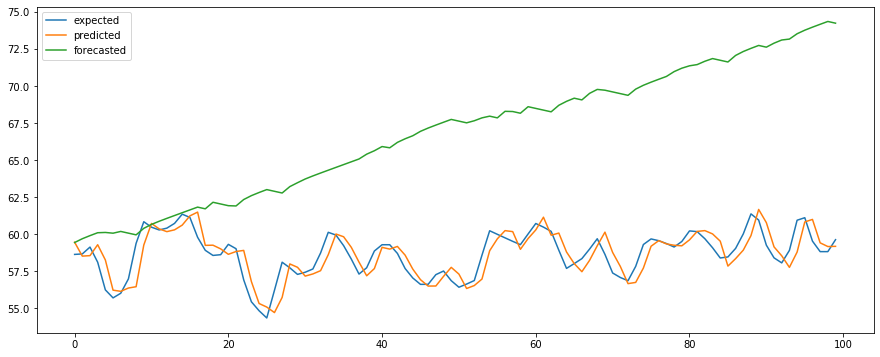

In [0]:
# line plot of observed vs predicted
plt.plot(expected_x, label="expected")
plt.plot(predictions, label="predicted")
plt.plot(forecasted[2:], label="forecasted")
plt.legend()
plt.show()